<div align="center">
    <img src='../../xepimage.png' style='height:100px;'>
</div>


<center><h1 style='font-size:25px'>Model</h1></center>

---

**Autor: Guillermo J. Bergues**

AutoluOn model for Xepelin project.

Data = outliers (second aproach).

In [1]:
! /opt/miniconda3/envs/myenv/bin/pip install --no-cache-dir autogluon -q

In [2]:
import pandas as pd 
import numpy as np

from autogluon.tabular import TabularPredictor, TabularDataset

# Metrics
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv ('../../Data/ds_outliers.csv')

In [4]:
df.head()

,PayerId,ReceiverId,days,amount,amountfinancedByXepelin
0,151,19,0,1490.46,0.00
1,126,18,0,920.26,0.00
2,114,37,7,4035.26,0.00
3,122,12,10,27979.20,10520.15
4,55,34,22,1477.46,0.00


<AxesSubplot:>

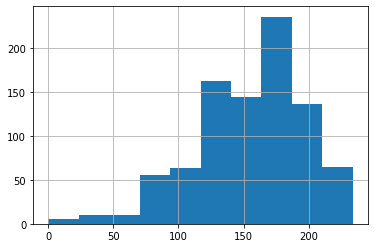

In [5]:
df['days'].hist()

In [6]:
save_path = "agModels"

In [7]:
df_train = df[df["days"] < 180]

In [8]:
label = 'amount'

In [9]:
df_train = TabularDataset(df)

In [10]:
predictor = TabularPredictor(label=label, path=save_path, eval_metric='median_absolute_error').fit(df_train, time_limit=18000)

Beginning AutoGluon training ... Time limit = 18000s
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.4.2
Python Version:     3.8.10
Operating System:   Linux
Train Data Rows:    891
Train Data Columns: 4
Label Column: amount
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1447597.9, 58.16, 27003.67114, 106054.56881)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    63556.61 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manua

In [11]:
test_data = df[df["days"] >= 180]

In [12]:
df_test = TabularDataset(test_data)

In [13]:
# values to predict
y_test = df_test[label]  

In [14]:
# delete label column to prove we're not cheating
test_data_nolab = df_test.drop(columns=[label])  

In [15]:
test_data_nolab.head()

,PayerId,ReceiverId,days,amountfinancedByXepelin
627,174,82,182,0.0
628,187,55,182,0.0
629,173,35,183,5220.0
630,110,46,183,0.0
631,199,46,183,0.0


In [16]:
predictor = TabularPredictor.load(save_path)  

In [17]:
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)

Predictions:  
 627     1363.191650
628     1338.256348
629    10305.122070
630     1408.709229
631     1369.623413
           ...     
886     1370.267334
887     1559.723145
888     1372.821533
889     1676.446289
890     1485.379150
Name: amount, Length: 264, dtype: float32


In [18]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: median_absolute_error on test data: -235.59089111328126
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "median_absolute_error": -235.59089111328126,
    "root_mean_squared_error": -29026.452276982633,
    "mean_squared_error": -842534931.7879503,
    "mean_absolute_error": -7868.054821388937,
    "r2": 0.7536539962537405,
    "pearsonr": 0.9320078996635309
}


In [19]:
# Predictions and test data set
df_test_pred = pd.concat([y_test, y_pred], axis=1)
df_test_pred.columns = ['test', 'prediction']
df_test_pred['residual'] = df_test_pred['test'] - df_test_pred['prediction']
df_test_pred.head()

,test,prediction,residual
627,1792.46,1363.191650,429.268350
628,725.46,1338.256348,-612.796348
629,5220.00,10305.122070,-5085.122070
630,4035.06,1408.709229,2626.350771
631,1490.26,1369.623413,120.636587


Text(0, 0.5, 'Predicted values')

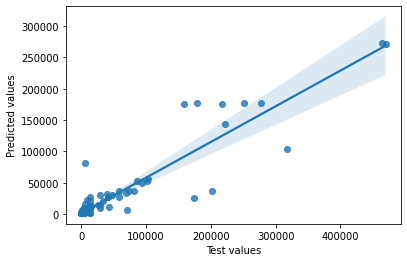

In [20]:
sns.regplot(x=y_test, y=y_pred);
plt.xlabel('Test values')
plt.ylabel('Predicted values')

In [21]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist,-0.000039,-661.757383,0.008645,0.007578,0.004389,0.008645,0.007578,0.004389,1,True,2
1,WeightedEnsemble_L2,-235.590891,-283.316567,0.187805,0.143278,2.037129,0.004451,0.000452,0.322794,2,True,12
2,XGBoost,-246.100000,-285.115029,0.009351,0.005796,0.452753,0.009351,0.005796,0.452753,1,True,9
3,ExtraTreesMSE,-334.688005,-1120.952891,0.086902,0.069241,0.616234,0.086902,0.069241,0.616234,1,True,7
4,NeuralNetTorch,-336.406504,-493.419961,0.031358,0.007941,1.389975,0.031358,0.007941,1.389975,1,True,10
5,RandomForestMSE,-344.192429,-1127.165488,0.087101,0.067789,0.645348,0.087101,0.067789,0.645348,1,True,5
6,KNeighborsUnif,-441.552898,-605.160117,0.007874,0.008435,0.004971,0.007874,0.008435,0.004971,1,True,1
7,LightGBMLarge,-556.355762,-1409.507797,0.013779,0.003504,0.862842,0.013779,0.003504,0.862842,1,True,11
8,LightGBM,-1026.905008,-2121.724131,0.006664,0.002855,0.377322,0.006664,0.002855,0.377322,1,True,4
9,CatBoost,-1178.317124,-1907.320273,0.004648,0.001951,3.413947,0.004648,0.001951,3.413947,1,True,6


In [22]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 7868.054821388937
MSE: 842534931.7879503
RMSE: 29026.452276982633


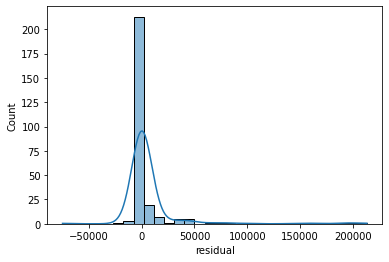

In [23]:
# Distributions of residuals
sns.histplot(data=df_test_pred, x='residual', kde=True, bins=30);

In [24]:
f_importance = predictor.feature_importance(df_test)
f_importance.head()

Computing feature importance via permutation shuffling for 4 features using 264 rows with 5 shuffle sets...
	4.79s	= Expected runtime (0.96s per shuffle set)
	1.42s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
amountfinancedByXepelin,331.884632,54.682199,0.000085,5,444.476035,219.293228
PayerId,25.875457,13.393682,0.006224,5,53.453233,-1.702320
days,15.288513,13.829456,0.034400,5,43.763555,-13.186529
ReceiverId,14.643375,24.666697,0.127528,5,65.432446,-36.145695
